In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['KaiTi'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

In [2]:
total_data = pd.read_excel('total_data.xlsx')
total_data.drop(columns=['storeId'],inplace=True)
total_data.head()

,date,storeName,customerNum,SKU,itemName,saleNum,Price,category,weekNum,low_temperature,high_temperature,air_quality,weather,holiday,income
0,2020-06-04,宠颐生上海金丰维康,22,C0304XX013,硕腾猫用大宠爱6%塞拉菌素0.75ml45mg（2.6-7.5kg）-集,1,90.00,猫猫驱虫药,23,30,22,56.0,2,0,8030
1,2020-06-04,宠颐生上海金丰维康,22,L000002633,勃林格梅里亚超可信阿福拉纳米尔贝肟咀嚼片XS9mg/2mg(2-3.5kg犬用）-集,1,125.00,狗狗驱虫药,23,30,22,56.0,2,0,8030
2,2020-06-04,宠颐生上海金丰维康,22,C0305XX005,海正海乐妙猫用米尔贝肟吡喹酮片14mg-集,1,29.91,猫猫驱虫药,23,30,22,56.0,2,0,8030
3,2020-06-04,宠颐生上海金丰维康,22,C0304XX054,勃林格梅里亚尼可信S阿福拉纳咀嚼片11mg（2-4kg犬用）-集,1,45.00,狗狗驱虫药,23,30,22,56.0,2,0,8030
4,2020-06-04,宠颐生上海金丰维康,22,C0304XX013,硕腾猫用大宠爱6%塞拉菌素0.75ml45mg（2.6-7.5kg）-集,1,90.00,猫猫驱虫药,23,30,22,56.0,2,0,8030


In [4]:
# add a new column
week_num = pd.to_datetime(total_data.date)
total_data['week_num'] = week_num.dt.week

get top 5 skus for 猫猫驱虫药 狗狗驱虫药 猫咪零食 狗狗零食

In [5]:
top_skus = {}
catogories = ['猫猫驱虫药', '狗狗驱虫药', '猫咪零食', '狗狗零食']
for catg in catogories:
    tops = list(total_data[total_data['category']==catg].groupby('itemName').sum()['saleNum'].sort_values(ascending=False)[:5].index)
    top_skus[catg]=tops

top_skus

{'猫猫驱虫药': ['硕腾猫用大宠爱6%塞拉菌素0.75ml45mg（2.6-7.5kg）-集',
  '勃林格梅里亚猫用博来恩复方非泼罗尼吡喹酮滴剂L（2.5-7.5kg）-集',
  '海正海乐妙猫用米尔贝肟吡喹酮片14mg-集',
  '勃林格梅里亚猫用博来恩复方非泼罗尼吡喹酮滴剂S（2.5kg以内）-集',
  '海正海乐妙猫用米尔贝肟吡喹酮片56mg-集'],
 '狗狗驱虫药': ['勃林格梅里亚超可信阿福拉纳米尔贝肟咀嚼片M38mg/8mg（7.5-15kg犬用）-集',
  '勃林格梅里亚超可信阿福拉纳米尔贝肟咀嚼片S19mg/4mg（3.5-7.5kg犬用）-集',
  '硕腾犬用大宠爱12%塞拉菌素0.5ml60mg（5.1-10kg）-集',
  '硕腾犬用大宠爱12%塞拉菌素0.25ml30mg（2.6-5kg）-集',
  '勃林格梅里亚超可信阿福拉纳米尔贝肟咀嚼片L75mg/15mg（15-30kg犬用）-集'],
 '猫咪零食': ['伊纳宝金的味道成猫粮鸡肉配方扇贝味60g-集',
  'King Kitty鱼籽酱-鲑鱼+南极磷虾15g-集',
  'King Kitty鱼籽酱-吞拿鱼+奶酪15g-集',
  '麦富迪kiss fish亲嘴鱼猫条(三文鱼)12g-集',
  'King Kitty鱼籽酱-鳕鱼15g-集'],
 '狗狗零食': ['伊纳宝旺好牛肉加入鸡小胸肉（成犬粮）100g-集',
  'wanpy顽皮犬用（活力营养）鸡肉+蔬菜鲜封包80g-集',
  '卡比进口鸡肉与三文鱼犬罐',
  '路斯牛肉粒-经典原味（小型犬专用）220g-集',
  '爱丽思犬罐头鸡肝100g-集']}

In [6]:
# weather only depends on time, so this is a dict storing all weeks and their (average) weather 
# (higher number = worse weather)
week_weather = {}
weeks = total_data.week_num.unique()
for w in weeks:
    avg_weather = total_data[total_data['weekNum']==w].groupby('date').mean()['weather'].mean()
    week_weather[w] = np.round(avg_weather, 3)

# DNN

My assumption is that all stores have similar sales trend for the same sku, so I'd first get the weekly sales(a series of sales) of the sku for each store, and then stack them together for training.
Use one sku in all stores to train, then test on this sku, a single store
Use all other skus in all stores to train, then test on single store, single sku

In [7]:
def get_sales(sku):
    # get weekly sales of sku for each store 
    stores = total_data['storeName'].unique()
    sales = {}
    for s in stores:
        tmp = total_data[total_data['storeName']==s]
        sale = tmp[tmp['itemName']==sku].groupby('week_num').sum()['saleNum'] # weekly sale (series)
        if len(sale)>=8:
            sales[s] = sale
    missing_weeks = []
    all_stores_with_with_sale = list(sales.keys()) # a list of stores that have sales (included in sales dictionary)
    for i in range(len(sales)):
        current_store_sale = sales[all_stores_with_with_sale[i]]
        all_week = list(range(current_store_sale.index[0],current_store_sale.index[-1]+1))
        missing_dates = list(set(all_week) - set(list(current_store_sale.index)))
        for j in missing_dates:
            # if a week has no sale, use 0 as a placeholder for continuity of data
            current_store_sale.loc[j]=0
            missing_weeks.append(i)
        current_store_sale.sort_index(inplace=True)
    return sales

now sales is a dictionary with store names as keys, and their corresponding weekly sales series as values

In [13]:
def lag_df(store_name):
    '''Returns a dataframe with lagged features for one store'''
    # create df with only sales column
    dict = {}
    sale = list(sales[store_name])
    for i in range(len(sale)):
        dict[i]=sale[i]
    df = pd.DataFrame.from_dict(dict,orient='index')
    df.columns = ['sales']
    data = pd.DataFrame(df['sales'].copy())

    # add the lags of the target variable
    for i in range(1, 5):
        data['lag_{}'.format(i)] = data['sales'].shift(i)

    # add window statistics e.g. rolling mean 
    lag_cols = [col for col in data.columns if 'lag' in col] # extract lag columns
    data['rolling_mean'] = data[lag_cols].mean(axis=1)
    
    # add lagged customerNum columns
    wk_with_sales = list(sales[store_name].index) # weeks that have sales for this sku
    store_df = total_data[total_data['storeName']==store_name]
    custnum = store_df.groupby('week_num').sum()['customerNum'] # custNum of all weeks
    cust = []
    for wk in list(custnum.index): # select weeks
        if wk in wk_with_sales:
            cust.append(custnum[wk]) 
    data['cust'] = cust   
    for i in range(1, 5): #lagging
        data['lag_{}_custNum'.format(i)] = data['cust'].shift(i)
    data.drop(columns=['cust'],inplace=True)

    # add lagged weather avg column
    weather = []
    for wk in wk_with_sales:
        weather.append(week_weather[wk])
    data['weather'] = weather
    for i in range(1, 5): #lagging
        data['lag_{}_weatherAvg'.format(i)] = data['weather'].shift(i)
    data.drop(columns=['weather'],inplace=True)

    data = data.dropna()
    return data
    
def stack_df(stores):
    df = lag_df(stores[0])
    for s in stores[1:]:
        tmp = lag_df(s)
        df = pd.concat([df, tmp], ignore_index=True)
    return df

In [14]:
def train_test_split(sales):
    full_data = stack_df(list(sales.keys()))    
    lens = []
    for k,v in sales.items():
        lens.append(len(v)-4)
    test_idx = []
    for i in range(1,4):
        test_idx.append(lens[0]-i)
    test_idx.sort()
    for j in lens[1:]:
        tmp = test_idx[-1]
        end = tmp+ j
        test_idx.append(end-2)
        test_idx.append(end-1)
        test_idx.append(end)
    train_idx = [i for i in list(full_data.index) if i not in test_idx]

    y_train = full_data.iloc[train_idx,0]
    y_test = full_data.iloc[test_idx,0]
    tmp = full_data.drop(columns = ['sales'])
    X_train = tmp.iloc[train_idx,:]
    X_test = tmp.iloc[test_idx,:]
    return X_train,y_train,X_test,y_test

## method 1

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

In [16]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def acc(y_true, y_pred):
    correct = 0
    for i in range(len(y_pred)):
        low = y_true.iloc[i]-y_true.iloc[i]*0.2
        high = y_true.iloc[i] + y_true.iloc[i]*0.2
        cur = y_pred[i]
        if cur<=high and cur>=low:
            correct+=1
    return correct/len(y_pred)
def plot_model_results(X_train,y_train,X_test,y_test, model, sku, test_size=0.3, plot_intervals=False, plot_anomalies=False):
    """
    - Plots modelled vs original values.
    - Prediction intervals (95% confidence interval).
    - Anomalies (points that resides outside the confidence interval).
    """
    model.fit(X_train, y_train)
    prediction = np.floor(model.predict(X_test))

    plt.figure(figsize=(15, 7))

    x = range(prediction.size)
    plt.plot(x, prediction, label='prediction', linewidth=2.0)
    plt.plot(x, y_test, label='actual', linewidth=2.0)
    if plot_intervals:
        timeseries_cv = TimeSeriesSplit(n_splits=5)
        cv = cross_val_score(model, X_train, y_train, 
                             cv=timeseries_cv, scoring='neg_mean_absolute_error')
        mae = -1 * cv.mean()
        deviation = cv.std()

        # 95% confidence interval
        scale = 1.96
        margin_error = mae + scale * deviation
        lower = prediction - margin_error
        upper = prediction + margin_error

        fill_alpha = 0.2
        fill_color = '#66C2D7'
        plt.fill_between(x, lower, upper, color=fill_color, alpha=fill_alpha, label='95% CI')      

        if plot_anomalies:
            anomalies = np.array([np.nan] * len(y_test))
            anomalies[y_test < lower] = y_test[y_test < lower]
            anomalies[y_test > upper] = y_test[y_test > upper]
            plt.plot(anomalies, 'o', markersize=10, label='Anomalies')

    MAPE = mean_absolute_percentage_error(prediction, y_test)
    MAE = mean_absolute_error(y_test,prediction)
    RMSE = np.sqrt(mean_squared_error(y_test,prediction))
    plt.title('{} Acc {:.2f}'.format(sku, acc(y_test,prediction)))
    plt.legend(loc='best')
    plt.tight_layout()
    plt.grid(True)
    return model

In [17]:
def tuning(X_train,y_train):
    rf = RandomForestRegressor()
    distributions = dict(n_estimators = [50,80,110,150,180], max_depth=[50,80,110,140,170])
    clf = RandomizedSearchCV(rf, distributions, random_state=0)
    search = clf.fit(X_train, y_train)
    model = RandomForestRegressor(max_depth=search.best_params_['max_depth'],n_estimators=search.best_params_['n_estimators'])
    return model

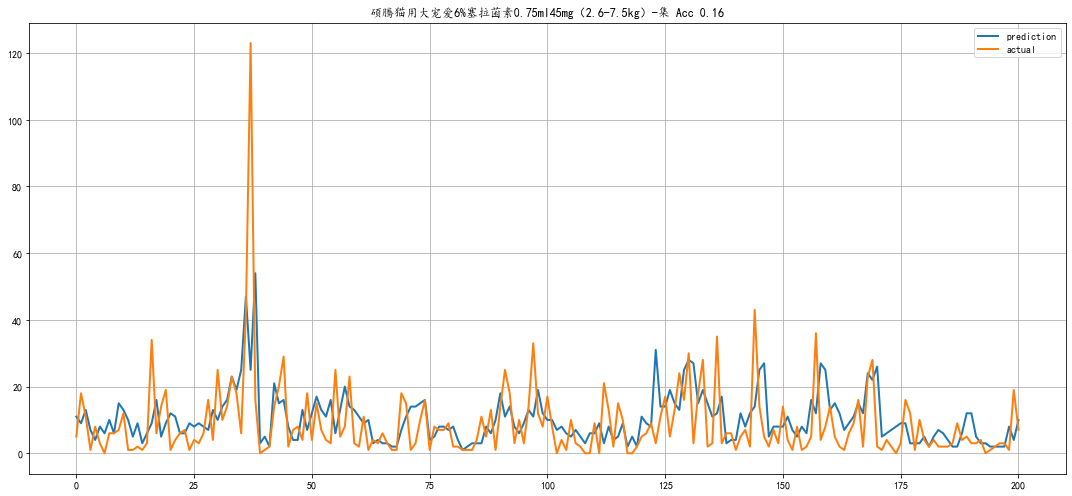

done


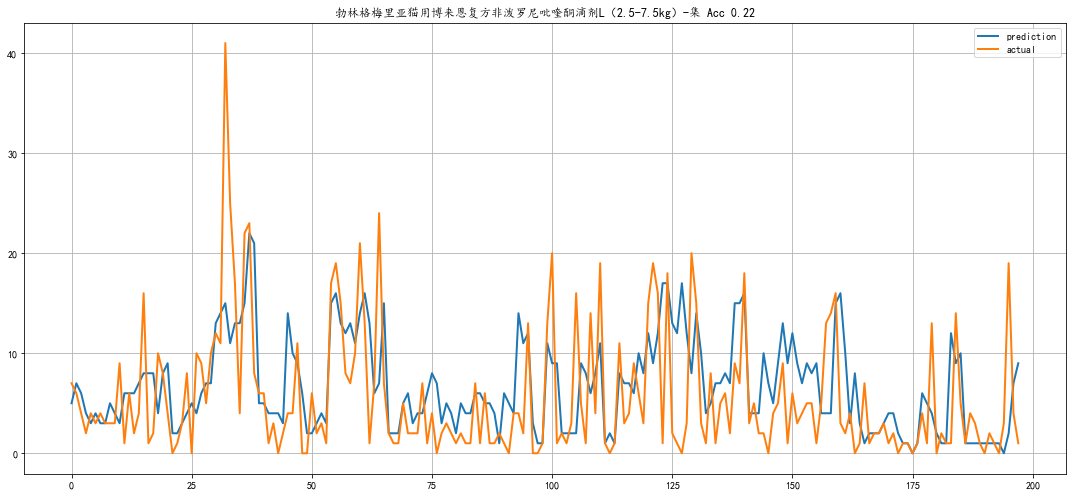

done


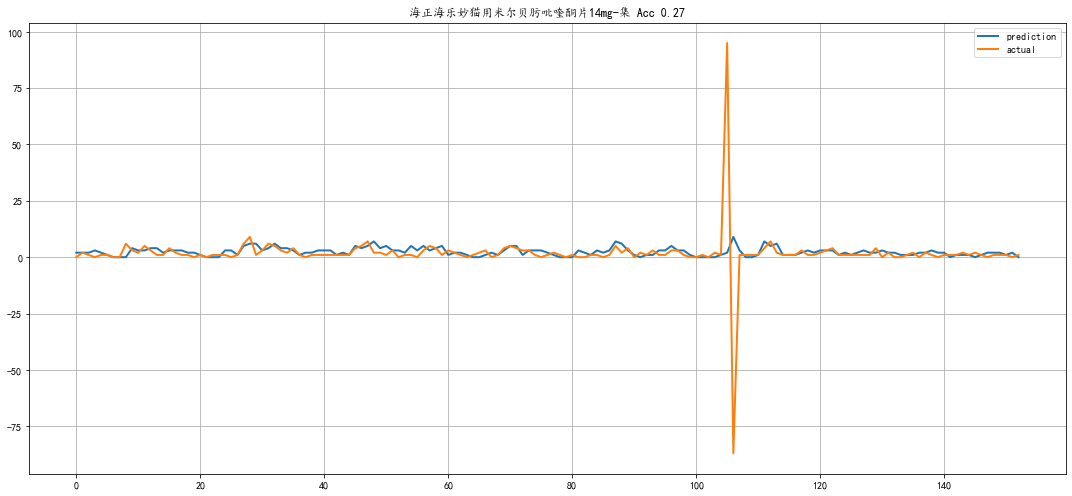

done


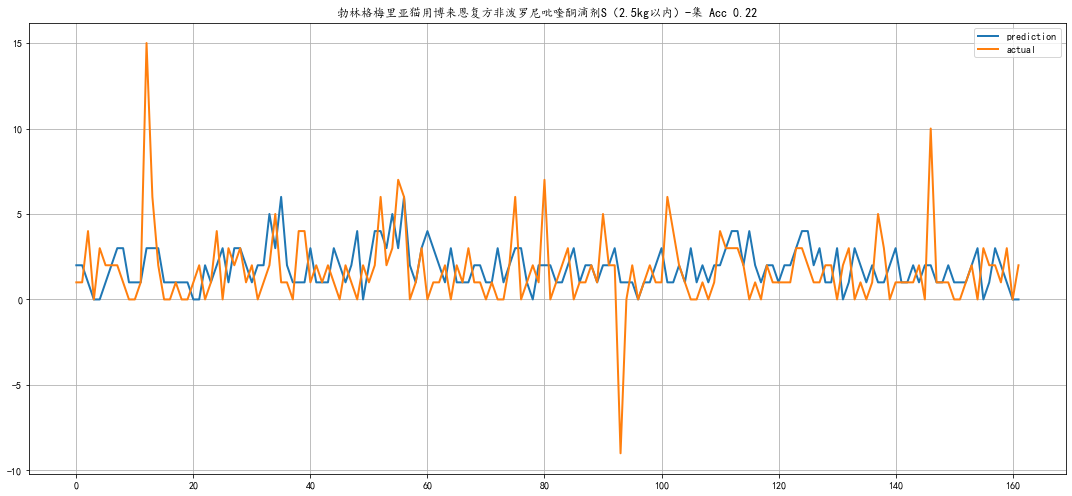

done


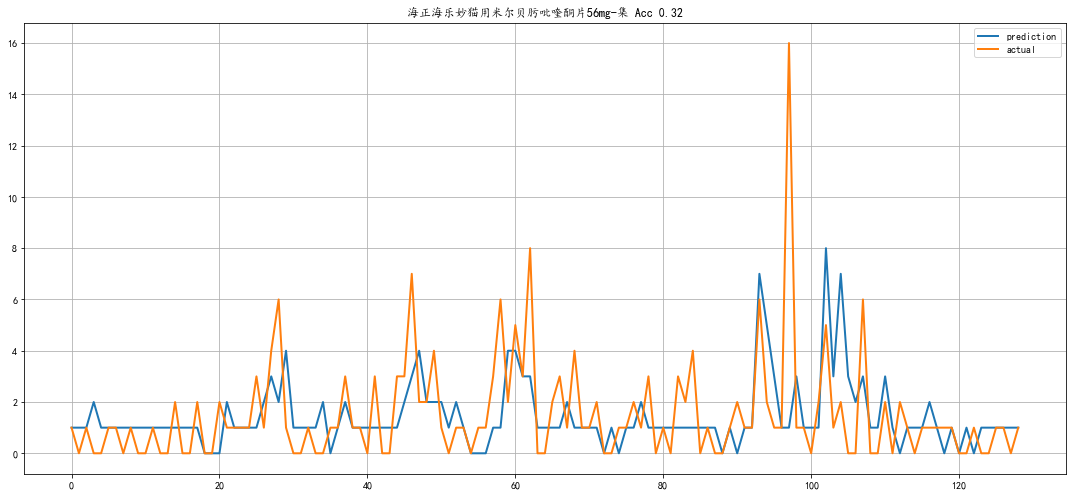

done


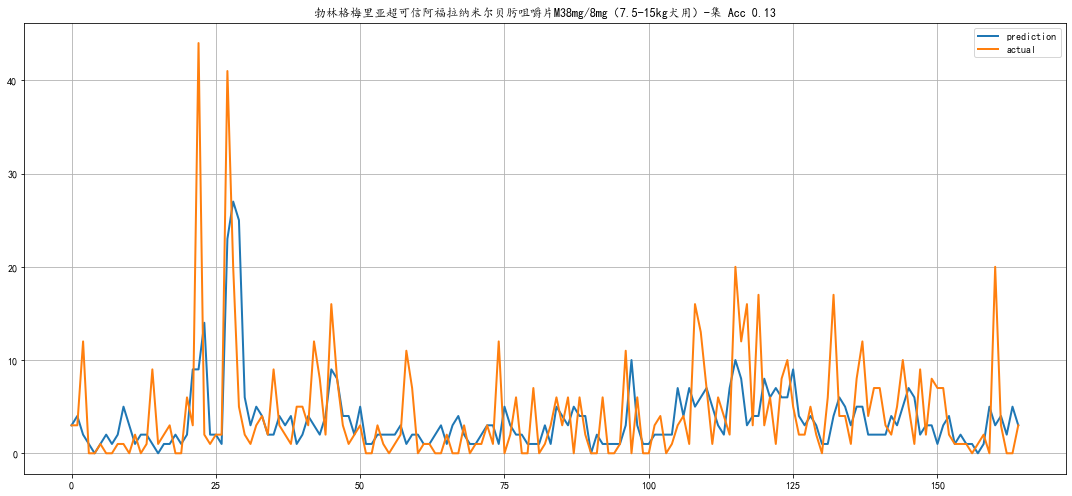

done


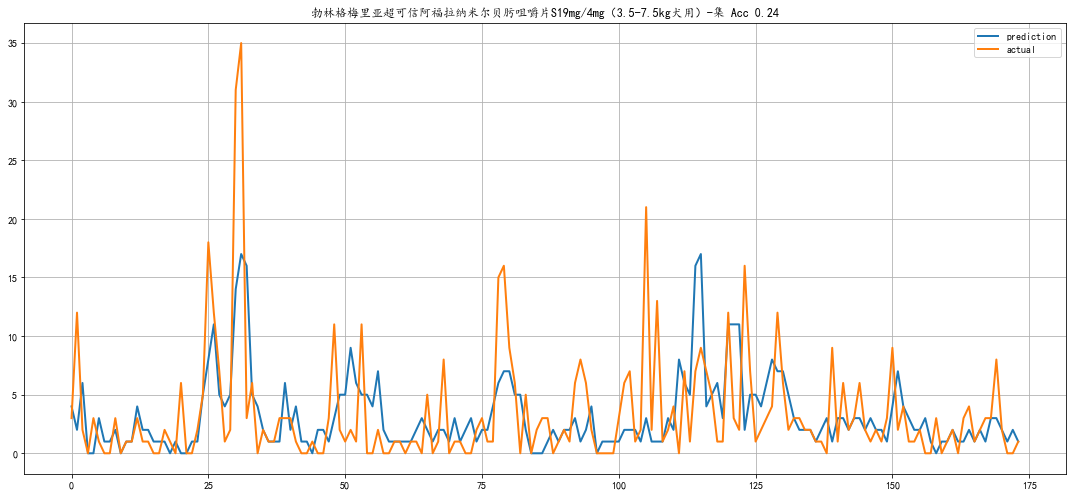

done


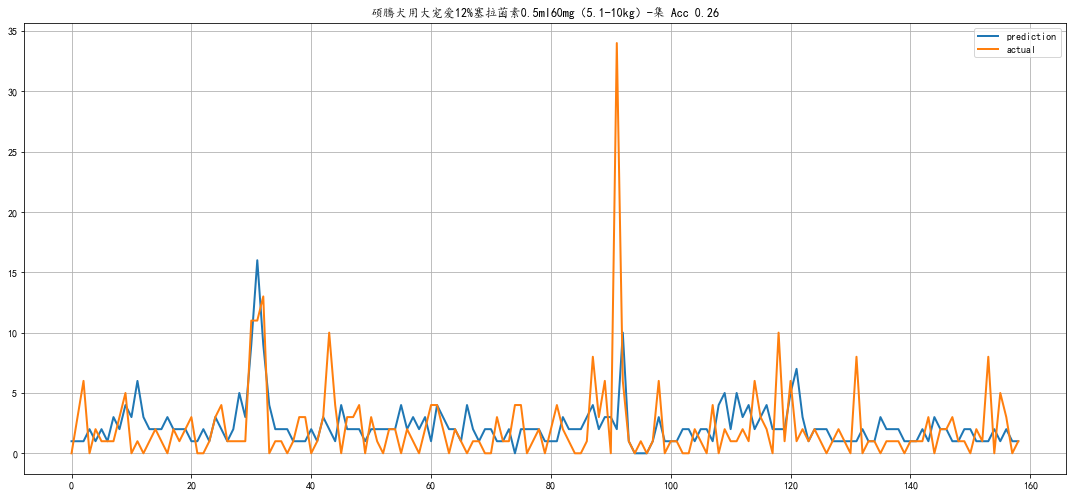

done


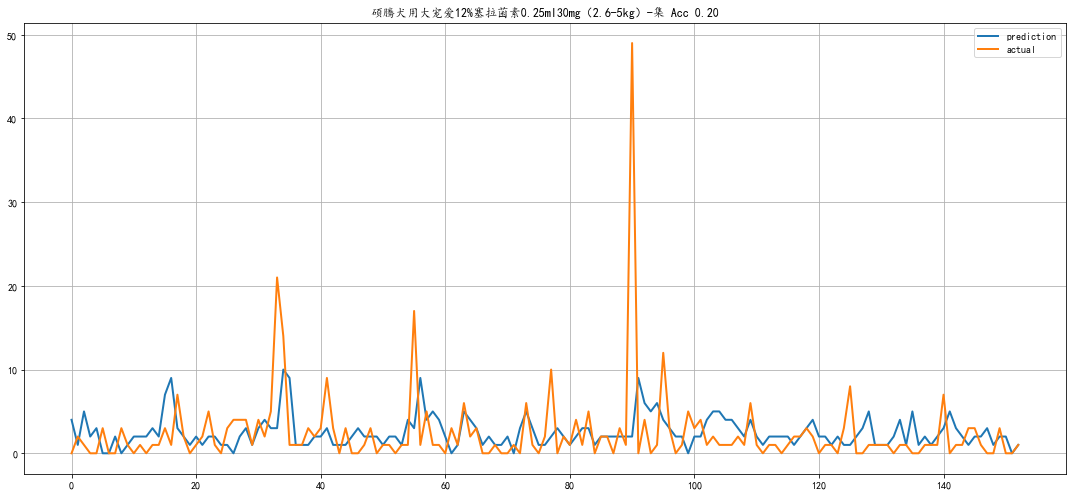

done


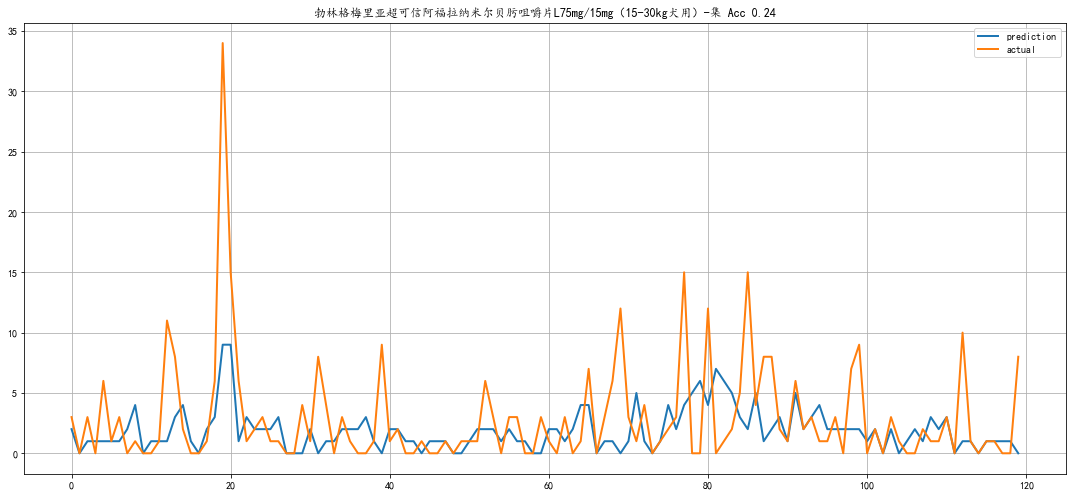

done


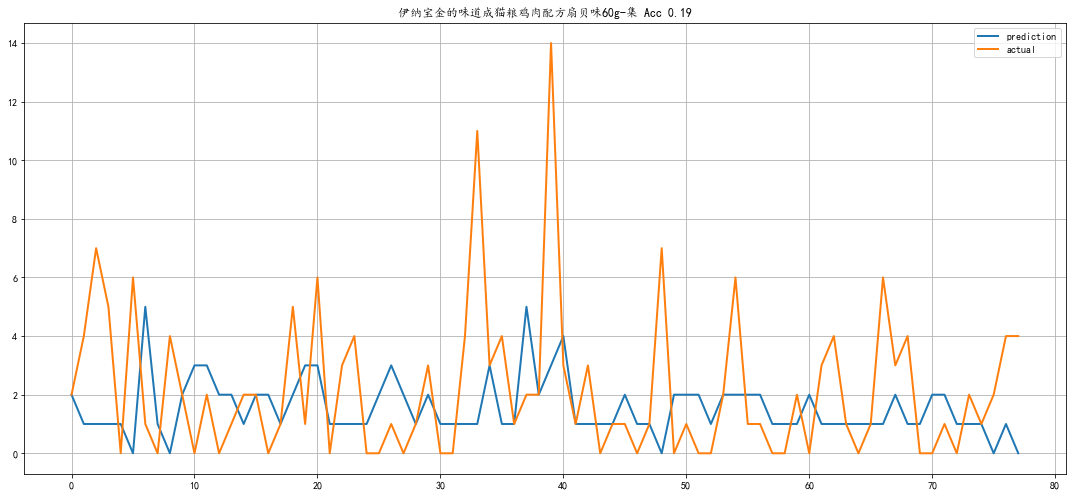

done


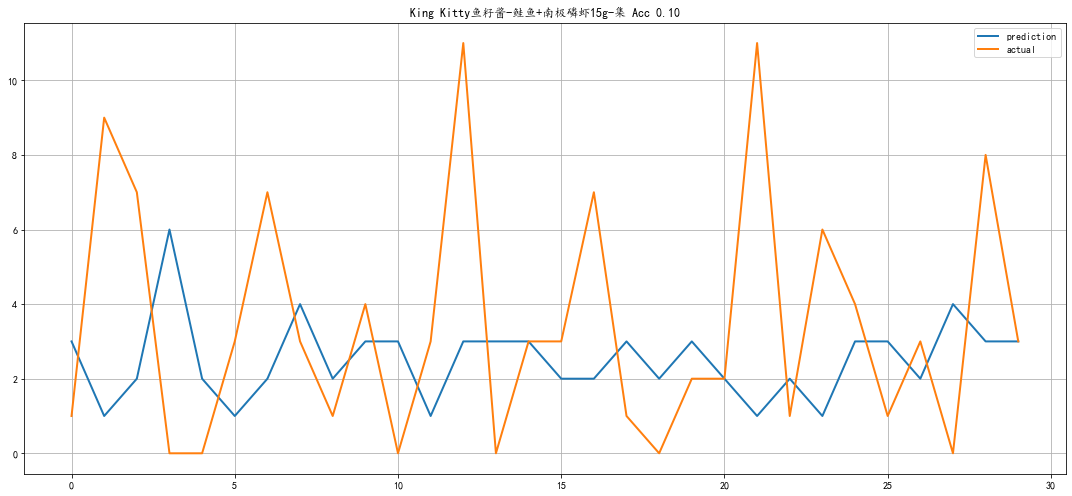

done


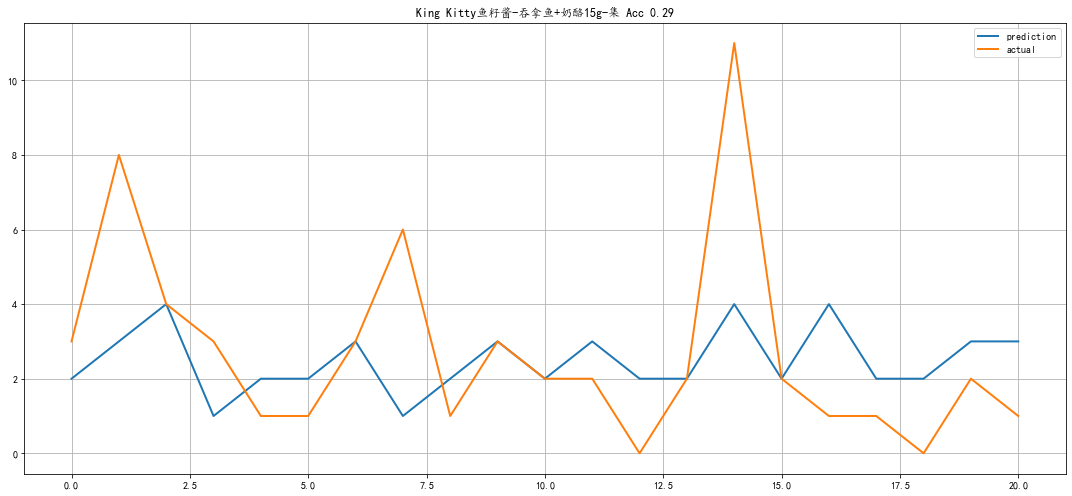

done


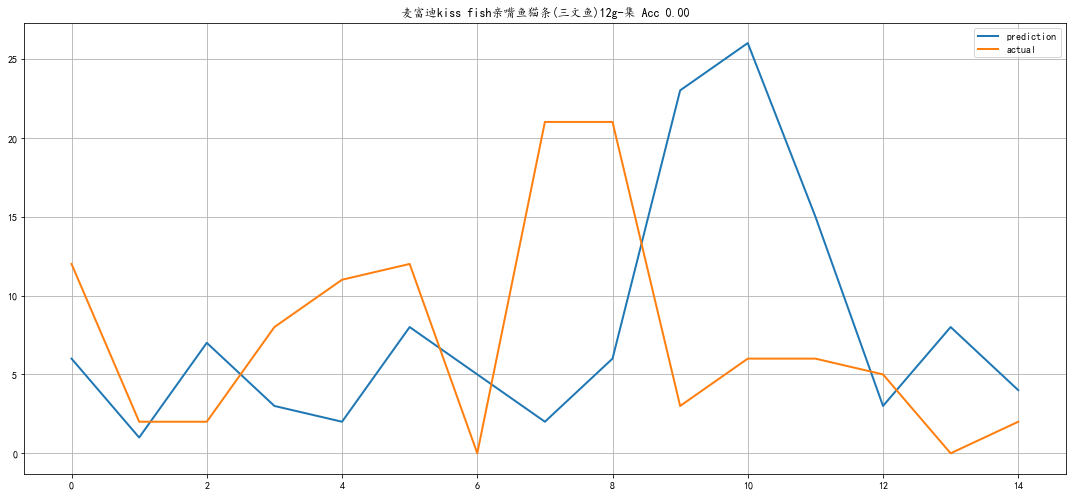

done


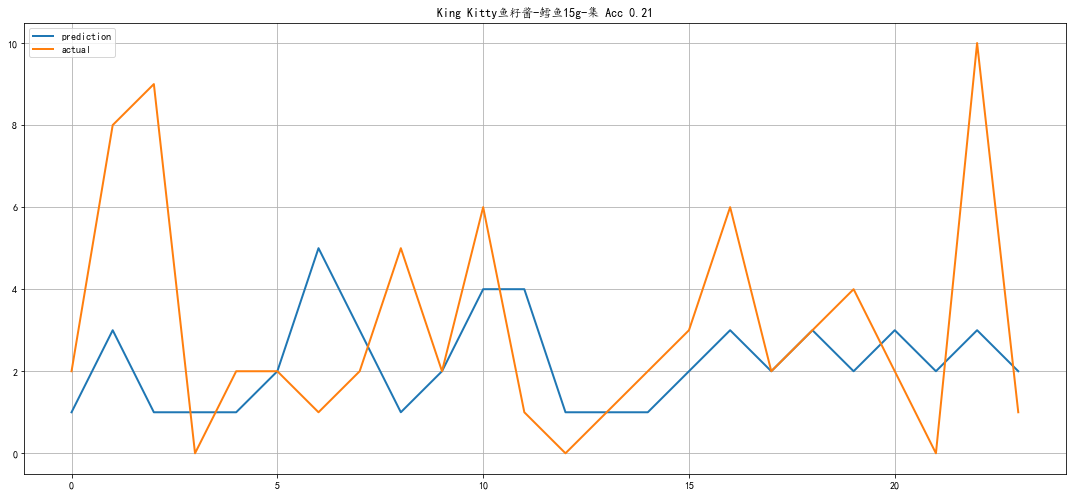

done


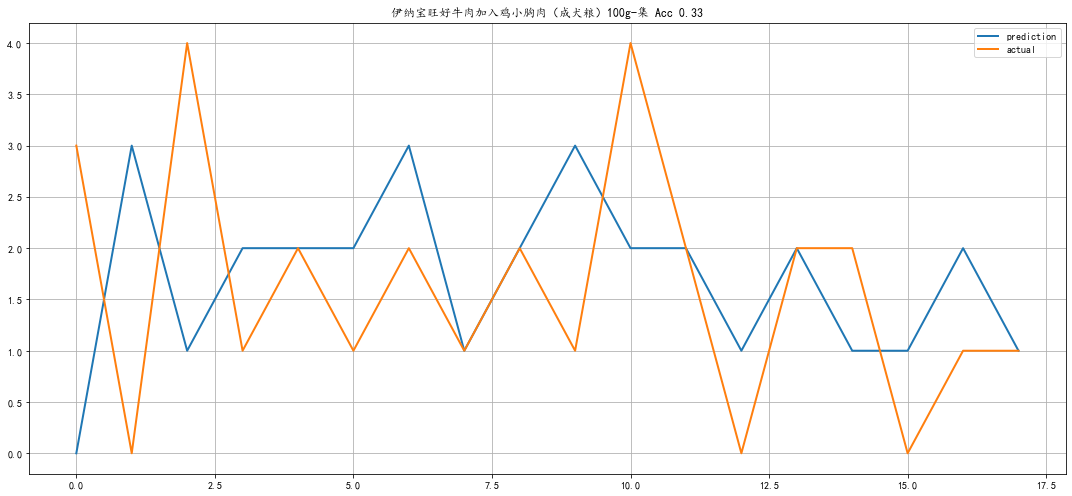

done


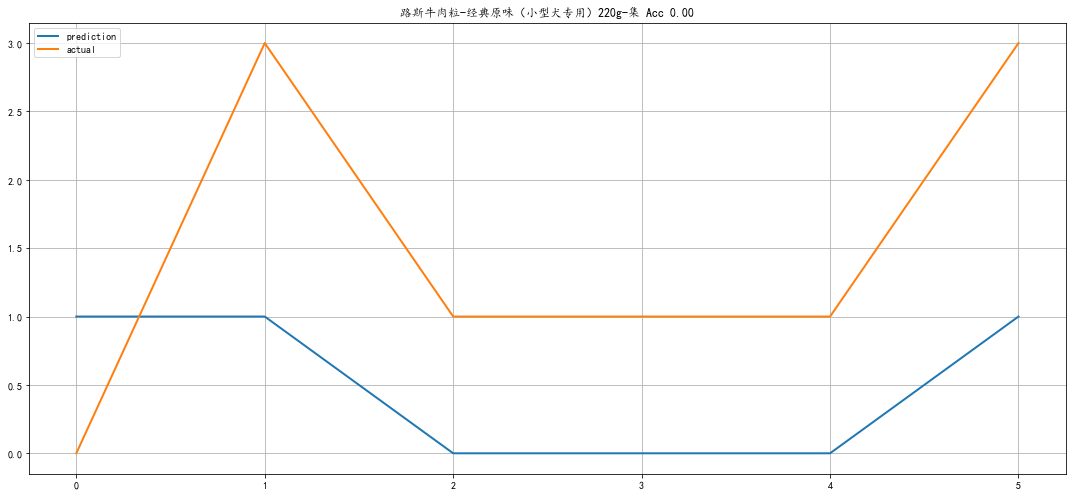

done


In [18]:
for k,v in top_skus.items():
    for i in v:
        try:
            sales = get_sales(i)
            X_train,y_train,X_test,y_test = train_test_split(sales)
            rf = tuning(X_train,y_train)
            plot_model_results(X_train,y_train,X_test,y_test,rf,i)
            plt.show()
            print('done')
        except IndexError:
            continue

## method 2 (not used)

In [79]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)
# choose a step size of 4 (a month)
n_steps = 4
n_features = 1

In [80]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense

In [94]:
X, y = split_sequence(values[0], n_steps) 
for i in range(1,len(values)-2): # save two stores' data for testing
    # split into samples
    tmp_X, tmp_y = split_sequence(values[i], n_steps)
    if len(tmp_X)!=0:
        # stack shaped data on th-e previous
        X = np.vstack((X,tmp_X))
        y = np.append(y,tmp_y)

In [96]:
split = int(np.round(0.7*X.shape[0]))
X_train = X[:split]
y_train = y[:split]
X_val = X[split:]
y_val = y[split:]

In [99]:
model_dnn = Sequential()
model_dnn.add(Dense(100, activation='relu', input_dim=n_steps))
model_dnn.add(Dense(1))
model_dnn.compile(optimizer='adam', loss='mse')
# fit model
model_dnn.fit(X_train, y_train, epochs=500, verbose=0)

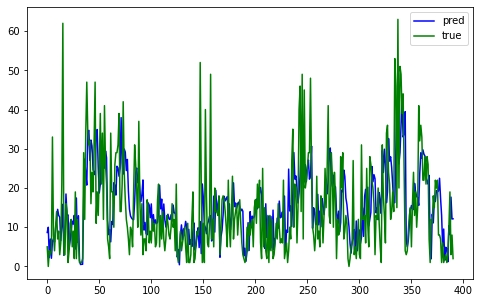

In [135]:
plt.figure(figsize=(8,5))
plt.plot(range(len(y_val)),model_dnn.predict(X_val),c='blue',label='pred')
plt.plot(range(len(y_val)),y_val,c='green',label='true')
plt.legend()

In [130]:
# prepare test data (two remaining stores)
X_test_1, y_test_1 = split_sequence(values[-1][:-1], n_steps)
X_test_2, y_test_2 = split_sequence(values[-2][:-1],n_steps)

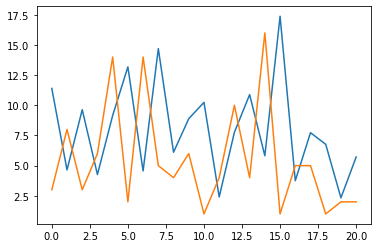

In [134]:
# use trained model to get prediction on test data
plt.plot(range(len(y_test_2)),model_dnn.predict(X_test_2))
plt.plot(range(len(y_test_2)),y_test_2)
# plt.plot(range(len(y_test_1)),model_dnn.predict(X_test_1))
# plt.plot(range(len(y_test_1)),y_test_1)